# Plots of null geodesics in Kerr spacetime
## Computation with `kerrgeodesic_gw`

This Jupyter/SageMath notebook is relative to the lectures
[Geometry and physics of black holes](https://luth.obspm.fr/~luthier/gourgoulhon/bh16/).

It requires [SageMath](http://www.sagemath.org/) (version $\geq$ 8.2), with the package [kerrgeodesic_gw](https://github.com/BlackHolePerturbationToolkit/kerrgeodesic_gw) (version $\geq$ 0.3.2). To install the latter, simply run 
```
sage -pip install kerrgeodesic_gw
```
in a terminal.

In [1]:
version()

'SageMath version 9.2, Release Date: 2020-10-24'

First, we set up the notebook to use LaTeX-formatted display:

In [2]:
%display latex

and we ask for CPU demanding computations to be performed in parallel on 8 processes:

In [3]:
Parallelism().set(nproc=8)

A Kerr black bole is entirely defined by two parameters $(m, a)$, where $m$ is the black hole mass and $a$ is the black hole angular momentum divided by $m$.
In this notebook, we shall set $m=1$ and we denote the angular momentum parameter $a$ by the symbolic variable `a`, using `a0` for a specific numerical value:

In [4]:
a = var('a')
a0 = 0.95

The spacetime object is created as an instance of the class `KerrBH`:

In [5]:
from kerrgeodesic_gw import KerrBH
M = KerrBH(a)
print(M)

Kerr spacetime M


The Boyer-Lindquist coordinate $r$ of the event horizon:

In [6]:
rH = M.event_horizon_radius()
rH

sqrt(-a^2 + 1) + 1

In [7]:
rH0 = rH.subs({a: a0})
show(LatexExpr(r'r_+ = '), rH0)

r_+ =  1.31224989991992

In [8]:
show(LatexExpr(r'r_- = '),
     M.inner_horizon_radius().subs({a: a0}))

r_- =  0.687750100080080

The method `boyer_lindquist_coordinates()` returns the chart of Boyer-Lindquist coordinates `BL` and allows the user to instanciate the Python variables `(t, r, th, ph)` to the coordinates $(t,r,\theta,\phi)$:

In [9]:
BL.<t, r, th, ph> = M.boyer_lindquist_coordinates()
BL

Chart (M, (t, r, th, ph))

The metric tensor is naturally returned by the method `metric()`:

In [10]:
g = M.metric()
g.display()

g = -(a^2*cos(th)^2 + r^2 - 2*r)/(a^2*cos(th)^2 + r^2) dt*dt - 2*a*r*sin(th)^2/(a^2*cos(th)^2 + r^2) dt*dph + (a^2*cos(th)^2 + r^2)/(a^2 + r^2 - 2*r) dr*dr + (a^2*cos(th)^2 + r^2) dth*dth - 2*a*r*sin(th)^2/(a^2*cos(th)^2 + r^2) dph*dt + (2*a^2*r*sin(th)^4 + (a^2*r^2 + r^4 + (a^4 + a^2*r^2)*cos(th)^2)*sin(th)^2)/(a^2*cos(th)^2 + r^2) dph*dph

### Functions $\ell(r_0)$ and $q(r_0)$ for spherical photon orbits:

In [11]:
r = var('r')
lsph(a, r) = (r^2*(3 - r) - a^2*(r + 1))/(a*(r -1))
lsph

(a, r) |--> -(a^2*(r + 1) + (r - 3)*r^2)/(a*(r - 1))

In [12]:
qsph(a, r) = r^3 / (a^2*(r - 1)^2) * (4*a^2 - r*(r - 3)^2)
qsph

(a, r) |--> -((r - 3)^2*r - 4*a^2)*r^3/(a^2*(r - 1)^2)

### $\theta$-turning points:

In [13]:
theta0(a, l, q) = arccos(sqrt(1/2*(1 - (l^2+q)/a^2 + sqrt((1 - (l^2+q)/a^2)^2 + 4*q/a^2))))
theta0

(a, l, q) |--> arccos(sqrt(1/2*sqrt(((l^2 + q)/a^2 - 1)^2 + 4*q/a^2) - 1/2*(l^2 + q)/a^2 + 1/2))

In [14]:
theta1(a, l, q) = arccos(sqrt(1/2*(1 - (l^2+q)/a^2 - sqrt((1 - (l^2+q)/a^2)^2 + 4*q/a^2))))
theta1

(a, l, q) |--> arccos(sqrt(-1/2*sqrt(((l^2 + q)/a^2 - 1)^2 + 4*q/a^2) - 1/2*(l^2 + q)/a^2 + 1/2))

### Plot of $\mathcal{R}(r)$ for various values of $(\ell, q)$

In [15]:
l = var('l', latex_name=r'\ell')
q = var('q')
R(a, l, q, r) = r^4 + (a^2 - l^2 - q)*r^2 + 2*(q + (l - a)^2)*r - a^2*q
R

(a, l, q, r) |--> r^4 - a^2*q + (a^2 - l^2 - q)*r^2 + 2*((a - l)^2 + q)*r

In [16]:
xmin = 1.2
xmax = 3.7
ymin = -10
ymax = 40

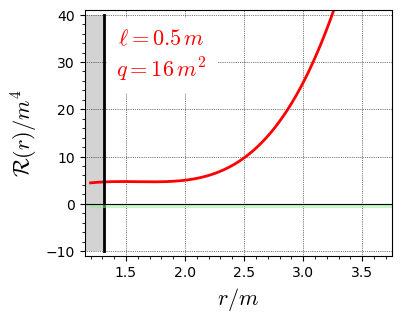

In [17]:
L = 0.5
Q = 16
g0 = plot(R(a0, L, Q, r), (r, xmin, xmax), color='red', thickness=2,         
          axes_labels=[r'$r/m$', r'$\mathcal{R}(r)/m^4$'],
          frame=True, gridlines=True)
g0 += line([(rH0, ymin), (rH0, ymax)], color='black', thickness=2)
g0 += line([(xmin, -0.4), (1.1*xmax, -0.4)], color='lightgreen', alpha=0.5, thickness=3)
g0 += polygon([(0.9*xmin, ymin), (rH0, ymin), (rH0, ymax), (0.9*xmin, ymax)], 
              color='lightgrey')
g0 += text(r'$\ell = 0.5\, m$', (1.8, 35), fontsize=16, color='red',
           background_color='white')
g0 += text(r'$q = 16\, m^2$', (1.8, 28.5), fontsize=16, color='red',
           background_color='white')
g0.set_axes_range(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
g0.set_aspect_ratio(0.04)
g0.save('gik_R_in_M1_1.pdf', figsize=5)
show(g0, figsize=5)

In [18]:
r0 = 2.2
L0 = lsph(a0, r0)
Q0 = qsph(a0, r0)
L0, Q0

(0.863157894736842, 18.0416251154201)

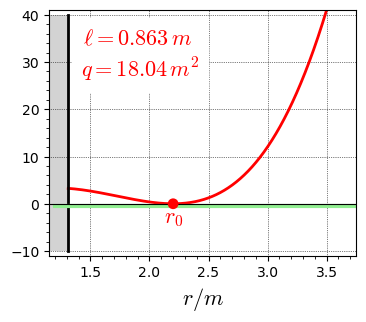

In [19]:
g1 = plot(R(a0, L0, Q0, r), (r, rH0, xmax), color='red', thickness=2,         
          axes_labels=[r'$r/m$', None],
          frame=True, gridlines=True)
g1 += line([(rH0, ymin), (rH0, ymax)], color='black', thickness=2)
g1 += line([(xmin, -0.4), (1.1*xmax, -0.4)], color='lightgreen', thickness=3)
g1 += point((r0, 0), size=60, color='red', zorder=100)
g1 += text(r'$r_0$', (r0, -2.8), color='red', fontsize=16)
g1 += text(r'$\ell = {:.3}\, m$'.format(float(L0)), (1.9, 35), fontsize=16, 
           color='red', background_color='white')
g1 += text(r'$q = {:.4}\, m^2$'.format(float(Q0)), (1.92, 28.5), fontsize=16, 
           color='red', background_color='white')
g1 += polygon([(0.9*xmin, ymin), (rH0, ymin), (rH0, ymax), (0.9*xmin, ymax)], 
              color='lightgrey')
g1.set_aspect_ratio(0.04)
g1.set_axes_range(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
g1.save('gik_R_in_M1_2.pdf', figsize=5)
show(g1, figsize=5)

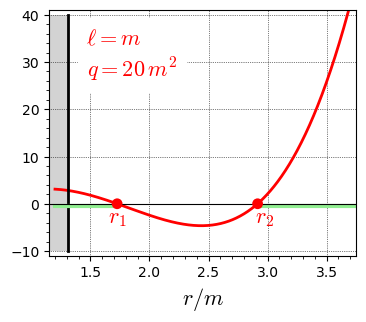

In [20]:
L = 1
Q = 20
r1 = find_root(R(a0, L, Q, r), rH0, r0)
r2 = find_root(R(a0, L, Q, r), r0, 4)
g2 = plot(R(a0, L, Q, r), (r, xmin, xmax), color='red', thickness=2,         
          axes_labels=[r'$r/m$', None],
          frame=True, gridlines=True)
g2 += line([(rH0, ymin), (rH0, ymax)], color='black', thickness=2)
g2 += line([(xmin, -0.4), (r1, -0.4)], color='lightgreen', thickness=3)
g2 += line([(r2, -0.4), (1.1*xmax, -0.4)], color='lightgreen', thickness=3)
g2 += point((r1, 0), size=60, color='red', zorder=100)
g2 += text(r'$r_1$', (r1, -2.8), color='red', fontsize=16)
g2 += point((r2, 0), size=60, color='red', zorder=100)
g2 += text(r'$r_2$', (1.02*r2, -2.8), color='red', fontsize=16)
g2 += text(r'$\ell = m$', (1.7, 35), fontsize=16, color='red',
           background_color='white')
g2 += text(r'$q = 20\, m^2$', (1.85, 28.5), fontsize=16, color='red',
           background_color='white')
g2 += polygon([(0.9*xmin, ymin), (rH0, ymin), (rH0, ymax), (0.9*xmin, ymax)], 
              color='lightgrey')
g2.set_aspect_ratio(0.04)
g2.set_axes_range(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
g2.save('gik_R_in_M1_3.pdf', figsize=5)
show(g2, figsize=5)

In [21]:
L = 2*rH0/a0
Q = 8
r2 = find_root(R(a0, L, Q, r), r0, 8)
L, Q, r2

(2.76263136825246, 8, 2.722847233324403)

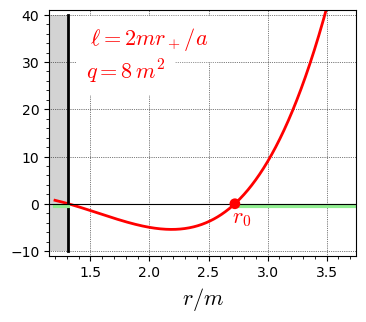

In [22]:
g3 = plot(R(a0, L, Q, r), (r, xmin, xmax), color='red', thickness=2,         
          axes_labels=[r'$r/m$', None],
          frame=True, gridlines=True)
g3 += line([(rH0, ymin), (rH0, ymax)], color='black', thickness=2)
g3 += line([(xmin, -0.4), (rH0, -0.4)], color='lightgreen', thickness=3)
g3 += line([(r2, -0.4), (1.1*xmax, -0.4)], color='lightgreen', thickness=3)
g3 += point((r2, 0), size=60, color='red', zorder=100)
g3 += text(r'$r_0$', (1.02*r2, -2.8), color='red', fontsize=16)
g3 += text(r'$\ell = 2mr_+/a$', (2, 35), fontsize=16, 
           color='red', background_color='white')
g3 += text(r'$q = 8 \, m^2$', (1.8, 28), fontsize=16, 
           color='red', background_color='white')
g3 += polygon([(0.9*xmin, ymin), (rH0, ymin), (rH0, ymax), (0.9*xmin, ymax)], 
              color='lightgrey')
g3.set_aspect_ratio(0.04)
g3.set_axes_range(xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
g3.save('gik_R_in_M1_4.pdf', figsize=5)
show(g3, figsize=5)

## Critical null geodesic

Parameters of a spherical photon orbit at $r_0 = 2.2m$:

In [23]:
r0 = 2.2
L0 = lsph(a0, r0)
Q0 = qsph(a0, r0)
L0, Q0

(0.863157894736842, 18.0416251154201)

Chosen parameters for the geodesic:

In [24]:
L = L0
Q = Q0
L, Q

(0.863157894736842, 18.0416251154201)

In [25]:
theta0(a0, L, Q)

0.195946218453965

In [26]:
r_init = 40
P = M.point((0, r_init, pi/2, 0), name='P')
print(P)

Point P on the Kerr spacetime M


A geodesic is constructed by providing the range $[\lambda_{\rm min},\lambda_{\rm max}]$ of the affine parameter $\lambda$, the initial point and either 
 - (i) the Boyer-Lindquist components $(p^t_0, p^r_0, p^\theta_0, p^\phi_0)$ of the initial 4-momentum vector
   $p_0 = \left. \frac{\mathrm{d}x}{\mathrm{d}\lambda}\right| _{\lambda_{\rm min}}$,
 - (ii) the four integral of motions $(\mu, E, L, Q)$
 - or (iii) some of the components of $p_0$ along with with some integrals of motion. 

In [27]:
lmax = 80 # lambda_max

In [28]:
Li = M.geodesic([0, lmax], P, mu=0, E=1, L=L, Q=Q, r_increase=False,
                a_num=a0, name='Li', latex_name=r'\mathcal{L}', verbose=True)

Initial tangent vector: 


p = 1.05260305969646 d/dt - 0.994675862738240 d/dr + 0.00265471463828243 d/dth + 0.000570385018106026 d/dph

The curve was correctly set.
Parameters appearing in the differential system defining the curve are [a].


The numerical integration of the geodesic equation is performed via `integrate()`, by providing the integration step $\delta\lambda$:

In [29]:
Li.integrate(step=0.0005, method='dopri5')
#Li.integrate(step=0.001)
Li.check_integrals_of_motion(0.999*lmax)

quantity,value,initial value,diff.,relative diff.
,,,,
,,,,
,,,,
,,,,


In [30]:
print("Final point: ")
show(BL[:], "=", BL(Li(0.999*lmax)))

Final point: 


(t, r, th, ph) '=' (206.66703023467483,
 2.2000863112656326,
 1.9511762444244498,
 53.094380043176905)

In [31]:
lplot = lmax
print("max lambda (plot): ", lplot)
graph1 = Li.plot(prange=(30, lplot), plot_points=2000, thickness=4, color='green',
                 display_tangent=True, scale=0.1, width_tangent=10, color_tangent='green', 
                 plot_points_tangent=12, horizon_color='lightgrey') \
         + line([(0,0,-3), (0,0,3)], color='black', thickness=2)
graph1

max lambda (plot):  80


Graphics3d Object

## Escaping null geodesic close to the critical one

In [32]:
L = 1.0001*L0
Q = Q0
L, Q

(0.863244210526316, 18.0416251154201)

In [33]:
theta0(a0, L, Q)

0.195965348586193

In [34]:
r_init = 40
P = M.point((0, r_init, pi/2, 0), name='P')
lmax = 80
Li = M.geodesic([0, lmax], P, mu=0, E=1, L=L, Q=Q, r_increase=False,
                a_num=a0, name='Li', latex_name=r'\mathcal{L}', verbose=True)

Initial tangent vector: 


p = 1.05260305700070 d/dt - 0.994675815686174 d/dr + 0.00265471463828243 d/dth + 0.000570438933462204 d/dph

The curve was correctly set.
Parameters appearing in the differential system defining the curve are [a].


In [35]:
Li.integrate(step=0.001, method='dopri5')
Li.check_integrals_of_motion(0.999*lmax)

quantity,value,initial value,diff.,relative diff.
,,,,
,,,,
,,,,
,,,,


In [36]:
print("Final point: ")
show(BL[:], "=", BL(Li(0.999*lmax)))

Final point: 


(t, r, th, ph) '=' (142.73493888601888,
 22.257873149906203,
 0.49847494769804584,
 23.336351331857166)

In [37]:
lplot = 0.8*lmax
print("max lambda (plot): ", lplot)
graph2 = Li.plot(prange=(30, lplot), plot_points=2000, thickness=4, color='green',
                display_tangent=True, scale=0.2, width_tangent=10, color_tangent='green', 
                plot_points_tangent=12, horizon_color='lightgrey') \
         + line([(0,0,-3), (0,0,3)], color='black', thickness=2)
graph2

max lambda (plot):  64.0000000000000


Graphics3d Object

## Trapped null geodesic close to the critical one

In [38]:
L = 0.9999*L0
Q = Q0
L, Q

(0.863071578947368, 18.0416251154201)

In [39]:
theta0(a0, L, Q)

0.195927088185978

In [40]:
r_init = 40
P = M.point((0, r_init, pi/2, 0), name='P')
lmax = 56.81
Li = M.geodesic([0, lmax], P, mu=0, E=1, L=L, Q=Q, r_increase=False,
                a_num=a0, name='Li', latex_name=r'\mathcal{L}', verbose=True)

Initial tangent vector: 


p = 1.05260306239223 d/dt - 0.994675909785857 d/dr + 0.00265471463828243 d/dth + 0.000570331102749847 d/dph

The curve was correctly set.
Parameters appearing in the differential system defining the curve are [a].


In [41]:
Li.integrate(step=0.0005, method='dopri5')
Li.check_integrals_of_motion(0.999*lmax)

/home/eric/sage/9.2/local/lib/python3.8/site-packages/scipy/integrate/_ode.py:1179: UserWarning: dopri5: larger nsteps is needed
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


quantity,value,initial value,diff.,relative diff.
,,,,
,,,,
,,,,
,,,,


In [42]:
print("Final point: ")
show(BL[:], "=", BL(Li(0.999*lmax)))

Final point: 


(t, r, th, ph) '=' (128.57773967099268, 1.3375219985463933, 1.267137358002562, 28.267159612791097)

In [43]:
lplot = lmax
print("max lambda (plot): ", lplot)
graph3 = Li.plot(prange=(30, lplot), plot_points=2000, thickness=4, color='orange',
                 plot_horizon=False) 
graph2 + graph3

max lambda (plot):  56.8100000000000


Graphics3d Object